In [1]:
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
#from tensorflow.python.keras.models import Sequential,Model
#from tensorflow.python.keras.layers import Dense, Dropout, BatchNormalization,Input, LSTM, Add, Subtract, Lambda
#from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
#from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
#from tensorflow.python.keras import regularizers,initializers
#import keras.backend as Kr


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
# Library for Gaussian process
# import GPy
##Library for visualization
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib;matplotlib.rcParams['figure.figsize'] = (10,10)
import pylab 
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# sess = tf.compat.v1.Session()
# tf.compat.v1.disable_eager_execution()

In [2]:
# import tensorflow as tf
# from tensorflow.python.keras import backend as K

# # adjust values to your needs
# config = tf.compat.v1.ConfigProto( device_count = {'GPU': 2 , 'CPU': 30} )
# sess = tf.compat.v1.Session(config=config) 
# K.set_session(sess)

#HeUniform = tf.keras.initializers.he_uniform()

In [3]:
df = pd.read_csv("data/synthetic_50000.csv")

In [4]:
df

,x,y,t,z
0,0.077215,0.041551,1,-1.272336
1,0.072648,0.173875,1,-2.647951
2,0.082932,0.225804,1,-0.722524
3,0.036818,0.371458,1,-0.767574
4,0.032222,0.454318,1,-0.247456
...,...,...,...,...
49995,0.956158,0.580209,500,-0.109243
49996,0.969825,0.660313,500,1.010137
49997,0.912834,0.769824,500,-0.361022
49998,0.976659,0.884030,500,-0.621155


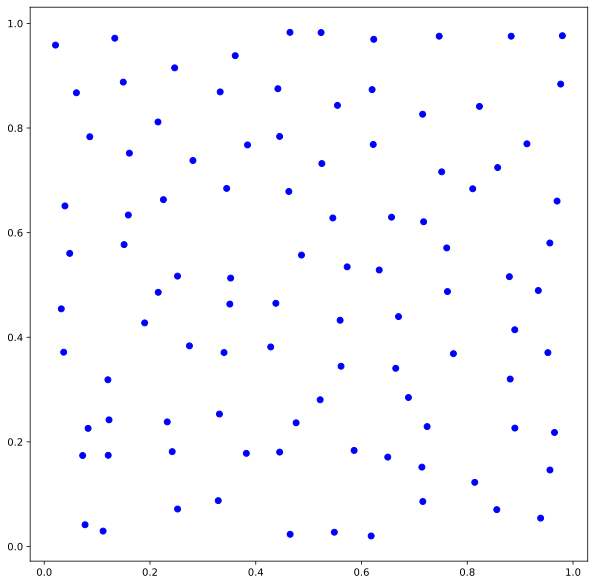

In [5]:
df2 = df[df.t == 1]
#df2
plt.plot(df2['x'], df2['y'], 'bo')

In [6]:
#df["x"] = df["V1"]
#df["y"] = df["V2"]
#df["t"] = df["V3"]

In [7]:
# test locations 
a = np.linspace(0,1,100)

s1, s2 = np.meshgrid(a,a)
s_test = np.column_stack((s1.flatten(),s2.flatten()))
s_test.shape

(10000, 2)

In [8]:
s_test

array([[0.        , 0.        ],
       [0.01010101, 0.        ],
       [0.02020202, 0.        ],
       ...,
       [0.97979798, 1.        ],
       [0.98989899, 1.        ],
       [1.        , 1.        ]])

In [9]:


s = np.array(df["t"]/500).reshape(len(df),1)
print(s.shape)
N_data = len(df)


(50000, 1)


In [10]:
s

array([[0.002],
       [0.002],
       [0.002],
       ...,
       [1.   ],
       [1.   ],
       [1.   ]])

In [11]:

t = np.array([250,350,450])/500
s_t = np.repeat(t, 10000).reshape(3*10000,1)
print(s_t.shape)


(30000, 1)


In [12]:
s_t

array([[0.5],
       [0.5],
       [0.5],
       ...,
       [0.9],
       [0.9],
       [0.9]])

In [13]:

s = np.vstack((s,s_t))
N = N_data + len(s_t)
print(N)


80000


In [14]:
s

array([[0.002],
       [0.002],
       [0.002],
       ...,
       [0.9  ],
       [0.9  ],
       [0.9  ]])

In [15]:

## time basis 
num_basis = [70,250,410]
std_arr = [0.2,0.09,0.009]
#std_arr = [0.3,0.15,0.05]
mu_knots = [np.linspace(0,1,int(i)) for i in num_basis]


In [16]:
phi_t = np.zeros((N, sum(num_basis)))
K = 0
res = 0
i = 0
d = np.square(np.absolute(s-mu_knots[res][i]))
d


array([[4.0e-06],
       [4.0e-06],
       [4.0e-06],
       ...,
       [8.1e-01],
       [8.1e-01],
       [8.1e-01]])

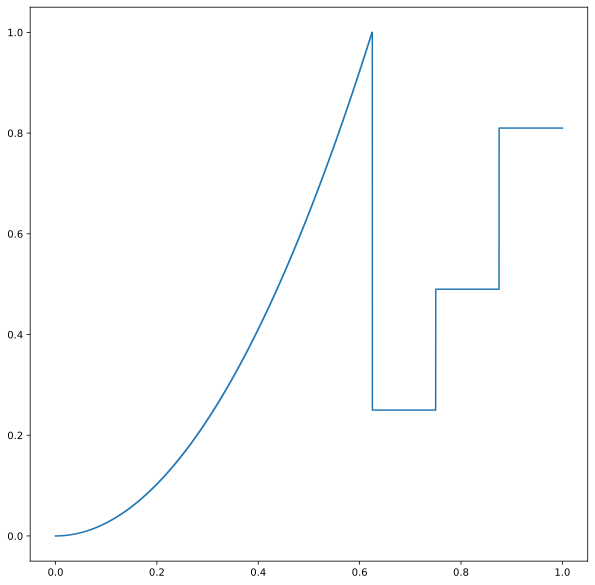

In [17]:
xd = np.linspace(0,1, 80000)
xd
plt.plot(xd, d)

In [18]:
phi_t = np.zeros((N, sum(num_basis)))
K = 0
res = 0
i = 0
d = np.square(np.absolute(s-mu_knots[res][i]))
std = std_arr[res]
for j in range(len(d)):
    if d[j] >= 0 and d[j] <= 1:
        phi_t[j,i + K] = np.exp(-0.5 * d[j]/(std**2))
    else:
        phi_t[j,i + K] = 0

/var/folders/ws/m03sh3xd4ns621mckfrht3r0000_08/T/ipykernel_50883/2673022059.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi_t[j,i + K] = np.exp(-0.5 * d[j]/(std**2))


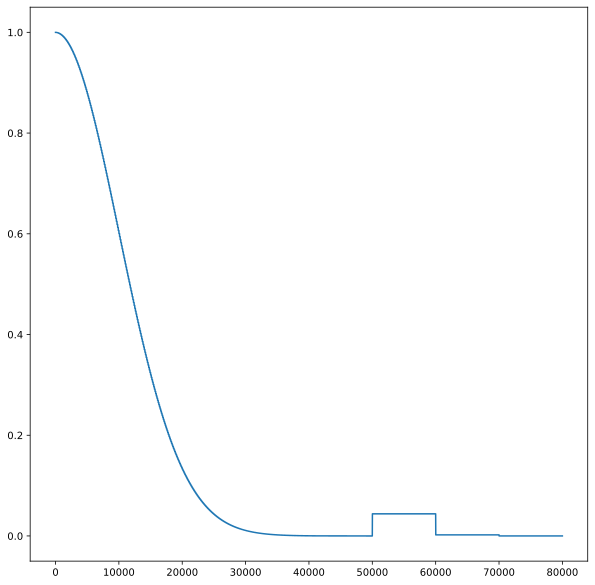

In [19]:
plt.plot(phi_t[:,0])

In [20]:
phi_t[:,0]

array([9.99950001e-01, 9.99950001e-01, 9.99950001e-01, ...,
       4.00652974e-05, 4.00652974e-05, 4.00652974e-05])

In [21]:

phi_t = np.zeros((N, sum(num_basis)))
K = 0
for res in range(len(num_basis)):
    std = std_arr[res]
    for i in range(num_basis[res]):
        d = np.square(np.absolute(s-mu_knots[res][i]))
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi_t[j,i + K] = np.exp(-0.5 * d[j]/(std**2))
            else:
                phi_t[j,i + K] = 0
    K = K + num_basis[res]


/var/folders/ws/m03sh3xd4ns621mckfrht3r0000_08/T/ipykernel_50883/1608306622.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  phi_t[j,i + K] = np.exp(-0.5 * d[j]/(std**2))


In [22]:
phi_t.shape

(80000, 730)

In [23]:


# # time basis
# num_basis = [3,7,11]
# knots = [np.linspace(0,1,i) for i in num_basis]
# ##Wendland kernel
# K = 0 ## basis size
# phi_t = np.zeros((N, sum(num_basis)))
# for res in range(len(num_basis)):
#     theta = 1/num_basis[res]*2.5
#     for i in range(num_basis[res]):
#         d = np.absolute(s-knots[res][i])/theta
#         for j in range(len(d)):
#             if d[j] >= 0 and d[j] <= 1:
#                 phi_t[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
#             else:
#                 phi_t[j,i + K] = 0
#     K = K + num_basis[res]

s = np.vstack((df["x"],df["y"])).T

s = np.vstack((s,s_test,s_test,s_test))

# space basis
num_basis = [5**2,9**2,11**2]
knots_1d = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]
##Wendland kernel
K = 0
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5
    knots_s1, knots_s2 = np.meshgrid(knots_1d[res],knots_1d[res])
    knots = np.column_stack((knots_s1.flatten(),knots_s2.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(s-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + K] = 0
    K = K + num_basis[res]

# phi2 = np.zeros((phi_t.shape[0],(phi_t.shape[1]*phi.shape[1])))

# for i in range(phi_t.shape[0]):
#     full_prod = []
#     for j in range(len(phi_t[i])):
#         if j == 0 : full_prod = phi[i]*phi_t[i,j]
#         else:
#             product = phi[i]*phi_t[i,j]
#             full_prod = np.concatenate((full_prod, product), axis=None)
#     phi2[i] = full_prod
            
        
        

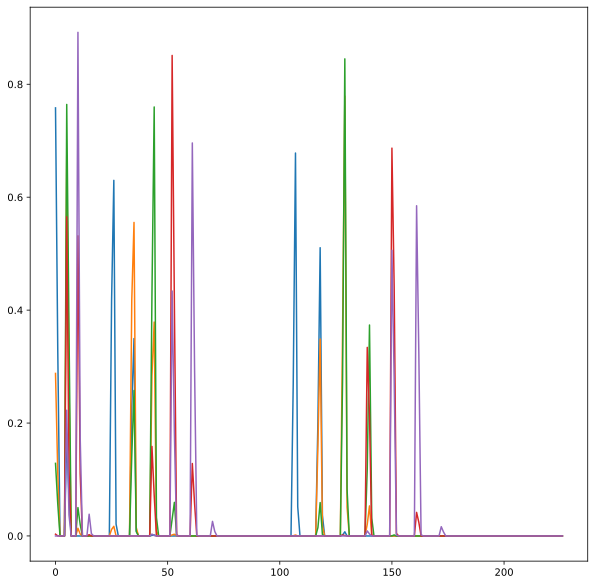

In [24]:
plt.plot(phi[0,:])
plt.plot(phi[1,:])
plt.plot(phi[2,:])
plt.plot(phi[3,:])
plt.plot(phi[4,:])
plt.show()


In [ ]:
print(phi_t.shape)
print(phi.shape)

phi2 = np.hstack((phi_t,phi))

In [ ]:
## Romove the all-zero columns
idx_zero = np.array([], dtype=int)
for i in range(phi2.shape[1]):
    if sum(phi2[:,i]!=0)==0:
        idx_zero = np.append(idx_zero,int(i))

phi_reduce = np.delete(phi2,idx_zero,1)
print(phi2.shape)
print(phi_reduce.shape)

In [ ]:
np.save("embedding_50k.npy", phi2)

In [ ]:
y = np.array(df["nonstat_z"])

In [ ]:
phi_reduce = np.load("embedding_50k.npy")
print(phi_reduce.shape)

In [ ]:
N_data = len(df)
phi_reduce_train = phi_reduce[0:N_data,]
phi_reduce_test = phi_reduce[N_data:phi_reduce.shape[0],]
print(phi_reduce_test.shape)
print(phi_reduce_train.shape)

## Deep Learning model 

In [ ]:
## Functions for calculation of MSE and MAE
def mse(y_pred,y_true):
    mse = np.mean((y_pred-y_true)**2)
    return mse

def mae(y_pred,y_true):
    mae = np.mean(np.absolute(y_pred-y_true))
    return mae

mse_var = []

In [ ]:
#### Modeling the median
start_time = time.time()
x_train,x_test,y_train, y_test= train_test_split(phi_reduce_train, y, 
                                                        test_size=0.1)

q = 0.5
def tilted_loss(y,f):

    e1 = (y-f)
    the_sum = (Kr.mean(Kr.maximum(q*e1, (q-1)*e1), axis=-1))
    return the_sum
#     data_train = np.hstack((encoder_train,y_train))
#     n_rows = data_train.shape[0]
#     random_indices = np.random.choice(n_rows, size=10000, replace=True)
#     resampled_data_train = data_train[random_indices, :]
# DeepKriging model for continuous data
model = Sequential()
# model.add(Dense(100, input_dim = 2,  kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(100, input_dim = x_train.shape[1],  
                kernel_initializer='he_uniform', activation='relu'))
# model.add(Dropout(rate=0.5))
# model.add(BatchNormalization())
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, kernel_regularizer=regularizers.L1L2(l1=1e-5,l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5),activation='relu'))
model.add(Dense(100, kernel_regularizer=regularizers.L1L2(l1=1e-5,l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5),activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
# model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
# model.add(Dense(50, activation='relu'))
#model.add(Dropout(rate=0.5))
#     model.add(Dense(10, activation='relu'))
#model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))
NB_START_EPOCHS = 50 
# NB_START_EPOCHS = 200  # Number of epochs we usually start to train with
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss=tilted_loss)

callbacks = [EarlyStopping(monitor='val_loss', patience= 30),
         ModelCheckpoint(filepath='model_real-50k.h5', monitor='val_loss', save_best_only=True)]
result = model.fit(x_train, y_train,callbacks = callbacks, 
                   validation_data=(x_test,y_test), epochs = 350, batch_size = 512, verbose = 2)




#     result = model.fit(x_train, y_train, callbacks=callbacks, 
#                        validation_data=(x_test,y_test), epochs = 200, batch_size = 64, verbose = 2)
model = keras.models.load_model('model_real-50k.h5',custom_objects={'tilted_loss':tilted_loss})
# y_pred = model.predict(x_test)

# Mean Squared Error
# mse_var.append(mean_squared_error(y_test, y_pred))


end_time = time.time()
print("%s seconds", end_time - start_time)


In [ ]:
#### Modeling the quantile functions 
start_time = time.time()
model1 = keras.models.load_model('model_real-50k.h5')
medY = model1.predict(phi_reduce_train)
x_train,x_test,y_train, y_test, medY_train, medY_test= train_test_split(phi_reduce_train, y, medY,
                                                        test_size=0.1)



q = 0.95
def tilted_loss(y,f):

    e1 = (y-f)
    the_sum = (Kr.mean(Kr.maximum(q*e1, (q-1)*e1), axis=-1))
    return the_sum
#     data_train = np.hstack((encoder_train,y_train))
#     n_rows = data_train.shape[0]
#     random_indices = np.random.choice(n_rows, size=10000, replace=True)
#     resampled_data_train = data_train[random_indices, :]
# DeepKriging model for continuous data
imp = Input(shape=x_train.shape[1])
input_medY = Input(shape = 1)
# model.add(Dense(100, input_dim = 2,  kernel_initializer='he_uniform', activation='relu'))
x = Dense(100,kernel_initializer='he_uniform', activation='relu')(imp)
# model.add(Dropout(rate=0.5))
# model.add(BatchNormalization())
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(100, kernel_regularizer=regularizers.L1L2(l1=1e-5,l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5),activation='relu')(x)
x = Dense(100, kernel_regularizer=regularizers.L1L2(l1=1e-5,l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5),activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
# model.add(Dense(100, activation='relu'))
x = Dense(50, activation='relu')(x)
x = Dense(50, activation='relu')(x)
x = Dense(50, activation='relu')(x)
x = Dense(50, activation='relu')(x)
# model.add(Dense(50, activation='relu'))
#model.add(Dropout(rate=0.5))
#     model.add(Dense(10, activation='relu'))
#model.add(BatchNormalization())
x = Dense(1, activation='sigmoid')(x)

x = Lambda(lambda d: d * 10)(x)
x = Add()([input_medY,x]) #### comment out for quantile 95
# x = Subtract()([input_medY,x]) #### comment out for quantile 05
model = Model(inputs=[imp, input_medY], outputs=x)

optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss=tilted_loss)

callbacks = [EarlyStopping(monitor='val_loss', patience= 30),
         ModelCheckpoint(filepath='model_real-50k_95.h5', monitor='val_loss', save_best_only=True)]
result = model.fit([x_train,medY_train], y_train,callbacks = callbacks, 
                   validation_data=([x_test,medY_test],y_test), epochs = 350, batch_size = 512, verbose = 2)




#     result = model.fit(x_train, y_train, callbacks=callbacks, 
#                        validation_data=(x_test,y_test), epochs = 200, batch_size = 64, verbose = 2)
# model = keras.models.load_model('model_real-50k_05.h5',custom_objects={'tilted_loss':tilted_loss})
# y_pred = model.predict(x_test)

# Mean Squared Error
# mse_var.append(mean_squared_error(y_test, y_pred))


end_time = time.time()
print("%s seconds", end_time - start_time)


In [ ]:
q = 0.95
def tilted_loss(y,f):

    e1 = (y-f)
    the_sum = (Kr.mean(Kr.maximum(q*e1, (q-1)*e1), axis=-1))
    return the_sum
model1 = keras.models.load_model('model_real-50k_05.h5',custom_objects={'tilted_loss':tilted_loss})
model2 = keras.models.load_model('model_real-50k_95.h5',custom_objects={'tilted_loss':tilted_loss})
model_med = keras.models.load_model('model_real-50k.h5')

In [ ]:
## Locations for interpolation



# t = (np.array(range(286)) + 1)/286
s = np.array(np.unique(df["t"]))/500

# print(s_t.shape)

# s = np.vstack((s,s_t))
N = 500
# print(N)

## time basis 
num_basis = [70,250,410]
std_arr = [0.2,0.09,0.009]
#std_arr = [0.3,0.15,0.05]
mu_knots = [np.linspace(0,1,int(i)) for i in num_basis]

phi_t = np.zeros((N, sum(num_basis)))
K = 0
for res in range(len(num_basis)):
    std = std_arr[res]
    for i in range(num_basis[res]):
        d = np.square(np.absolute(s-mu_knots[res][i]))
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi_t[j,i + K] = np.exp(-0.5 * d[j]/(std**2))
            else:
                phi_t[j,i + K] = 0
    K = K + num_basis[res]


# # time basis
# num_basis = [3,7,11]
# knots = [np.linspace(0,1,i) for i in num_basis]
# ##Wendland kernel
# K = 0 ## basis size
# phi_t = np.zeros((N, sum(num_basis)))
# for res in range(len(num_basis)):
#     theta = 1/num_basis[res]*2.5
#     for i in range(num_basis[res]):
#         d = np.absolute(s-knots[res][i])/theta
#         for j in range(len(d)):
#             if d[j] >= 0 and d[j] <= 1:
#                 phi_t[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
#             else:
#                 phi_t[j,i + K] = 0
#     K = K + num_basis[res]

s = np.repeat([[0.077215,0.041551]],500).reshape(500,2)

# space basis
num_basis = [5**2,9**2,11**2]
knots_1d = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]
##Wendland kernel
K = 0
phi = np.zeros((N, sum(num_basis)))
for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5
    knots_s1, knots_s2 = np.meshgrid(knots_1d[res],knots_1d[res])
    knots = np.column_stack((knots_s1.flatten(),knots_s2.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(s-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + K] = 0
    K = K + num_basis[res]
            
        
phi_test = np.hstack((phi_t,phi))        
phi_test.shape

In [ ]:
predictions = model.predict(phi_reduce_test)

In [ ]:
predictions.shape

In [ ]:
#### For single location prediction

df_pred1LOC = pd.DataFrame({"pred":predictions[:,0]})
df_pred1LOC.to_csv("1Loc_interpolation.csv", index=False)

In [ ]:
df_pred = pd.DataFrame({"x":s_test[:,0],"y":s_test[:,1]})

In [ ]:
df_pred["predictions_t250"] = predictions[0:10000,]
df_pred["predictions_t350"] = predictions[10000:20000,]
df_pred["predictions_t450"] = predictions[20000:30000,]

In [ ]:
pred_med.shape

In [ ]:
##### This section is only for storing the prediction intervals
df_pred = pd.read_csv("50k_interpolation.csv")
pred_med = model_med.predict(phi_reduce_test)
predictions1 = model1.predict([phi_reduce_test,pred_med])
predictions2 = model2.predict([phi_reduce_test,pred_med])

df_pred["lb_t250"] = predictions1[0:10000,]
df_pred["lb_t350"] = predictions1[10000:20000,]
df_pred["lb_t450"] = predictions1[20000:30000,]

df_pred["ub_t250"] = predictions2[0:10000,]
df_pred["ub_t350"] = predictions2[10000:20000,]
df_pred["ub_t450"] = predictions2[20000:30000,]

In [ ]:
df_pred.head()

In [ ]:
np.mean(df_pred["ub_t250"] - df_pred["lb_t250"])

In [ ]:
df_pred.to_csv("50k_interpolation.csv", index=False)

## Forecasting


In [ ]:
df = pd.read_csv("50k_lstm_data.csv")

In [ ]:
Z = np.array(df.iloc[:,5])

split_size = 495
train = Z[:split_size].reshape(split_size,1)
# test = Z[split:].reshape(65,1)

n_steps = 5
n_output = 1
training_size = split_size - (n_steps+n_output)

In [ ]:
x = np.zeros((training_size,n_steps,1))
y = np.zeros((training_size,n_output,1))

In [ ]:
for i in range(len(x)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(train)-1:
        break
    # gather input and output parts of the pattern
    seq_x, seq_y = train[i:end_ix], train[end_ix:(end_ix+n_output)]
    x[i] = seq_x
    y[i] = seq_y

In [ ]:
# indexes = np.arange(x.shape[0])
# train_index = indexes[: int(0.95 * x.shape[0])]
# val_index = indexes[int(0.95 * x.shape[0]) :]

# x_train, y_train = x[train_index],y[train_index]
# x_val, y_val = x[val_index],y[val_index]

In [ ]:

def model_function(q,x,y):
    def tilted_loss(y,f):

        e1 = (y-f)
        the_sum = (Kr.mean(Kr.maximum(q*e1, (q-1)*e1), axis=-1))
        return the_sum

    # define model
#     n_steps = 25
    n_features = 1
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    # model.add(Dropout(0.1))
    # model.add(LSTM(50, activation='relu',return_sequences=True))
    # model.add(Dropout(0.2))
    # model.add(LSTM(50, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dense(50, input_dim = x_train.shape[1],  
    #                 kernel_initializer='he_uniform', activation='relu'))
    # model.add(Dense(50, activation='relu'))
    # # model.add(Dense(50, activation='relu'))
    # model.add(Dense(10, activation='relu'))
    model.add(Dense(n_output,activation='linear'))
    optimizer = keras.optimizers.Adam(lr=0.001)
    model.compile(loss=tilted_loss, optimizer=optimizer)
    print("running model for quantile level "+str(q)+".")
    result1 = model.fit(x, y, #callbacks = callbacks, 
                    batch_size = 128, 
          validation_split = 0.05, epochs=120, verbose=0)
    return model

In [ ]:
# callbacks = [EarlyStopping(monitor='val_loss', patience=330),
#          ModelCheckpoint(filepath='lstm_2a_3.h5', monitor='val_loss', save_best_only=True)]

model1 = model_function(0.05,x,y)
model2 = model_function(0.5,x,y)
model3 = model_function(0.95,x,y)

In [ ]:
Z_test = Z[(split_size-n_steps):split_size].reshape(1,n_steps,1)
pred05 = np.empty((0,1))
pred5 = np.empty((0,1))
pred95 = np.empty((0,1))

for i in range(5):
    pred1 = model1.predict(Z_test)
    pred2 = model2.predict(Z_test)
    pred3 = model3.predict(Z_test)
    
    Z_test = np.append(Z_test[:,:(n_steps-1),:],pred2).reshape(1,n_steps,1)
    pred05 = np.append(pred05,pred1)
    pred5 = np.append(pred5,pred2)
    pred95 = np.append(pred95,pred3)

mean_pred = np.empty((0,1))

for i in range(len(x)):
    if i == (training_size - 1):
        pred2 = model2.predict(x[i,:,:].reshape(1,n_steps,1))
        mean_pred = np.append(mean_pred,pred2)
    else:
        pred2 = model2.predict(x[i,:,:].reshape(1,n_steps,1))
        mean_pred = np.append(mean_pred,pred2[:,0])


In [ ]:
test = Z[split_size:].reshape(5,1)
mse = mean_squared_error(pred5, test)
mse

In [ ]:
plt.plot(range(500), Z,label = "true")

# plt.scatter(range(959), x_train[:,0])
# plt.scatter(range(959), x_train[:,1])
plt.plot(range(6,495), mean_pred, label = "model mean")
plt.plot(range(495,500), pred05, label = "model 0.05")
plt.plot(range(495,500), pred5, label = "model 0.5")
plt.plot(range(495,500), pred95, label = "model 0.95")
# plt.plot(range(3,100), pred_list95, label = "model 0.95")

# plt.plot(range(97,100), pred_list[0,:], label = "model 0.05")
# plt.plot(range(97,100), pred_list[1,:], label = "model 0.5")
# plt.plot(range(97,100), pred_list[2,:], label = "model 0.95")

plt.axvline(x=495)
# plt.plot(range(959), pred_list[:,1])
# plt.plot(range(959), pred_list[:,2])

plt.legend()
plt.show()

In [ ]:
###### Run the model for all 50 time points #########
mse = np.empty((0,1))
mpiw = np.empty((0,1))
for ind in range(50):
    
    Z = np.array(df.iloc[:,ind])

    split_size = 495
    train = Z[:split_size].reshape(split_size,1)
    # test = Z[split:].reshape(65,1)

    n_steps = 5
    n_output = 1
    training_size = split_size - (n_steps+n_output)
    x = np.zeros((training_size,n_steps,1))
    y = np.zeros((training_size,n_output,1))
    for i in range(len(x)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(train)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = train[i:end_ix], train[end_ix:(end_ix+n_output)]
        x[i] = seq_x
        y[i] = seq_y
    
    model1 = model_function(0.05,x,y)
    model2 = model_function(0.5,x,y)
    model3 = model_function(0.95,x,y)
    Z_test = Z[(split_size-n_steps):split_size].reshape(1,n_steps,1)
    pred05 = np.empty((0,1))
    pred5 = np.empty((0,1))
    pred95 = np.empty((0,1))

    for i in range(5):
        pred1 = model1.predict(Z_test)
        pred2 = model2.predict(Z_test)
        pred3 = model3.predict(Z_test)

        Z_test = np.append(Z_test[:,:(n_steps-1),:],pred2).reshape(1,n_steps,1)
        pred05 = np.append(pred05,pred1)
        pred5 = np.append(pred5,pred2)
        pred95 = np.append(pred95,pred3)

#     for i in range(len(x)):
#         if i == 429:
#             pred2 = model2.predict(x[i,:,:].reshape(1,15,1))
#             mean_pred = np.append(mean_pred,pred2)
#         else:
#             pred2 = model2.predict(x[i,:,:].reshape(1,15,1))
#             mean_pred = np.append(mean_pred,pred2[:,0])
    mpiw = np.append(mpiw,np.mean(pred95 - pred05))
    test = Z[split_size:].reshape(n_steps,1)
    mse = np.append(mse,mean_squared_error(pred5, test))
    print(ind)
    print(mse)
    print(mpiw)
    print("################")

In [ ]:
pred05 = np.append(mean_pred,pred05)
pred95 = np.append(mean_pred,pred95)

pred5 = np.append(mean_pred,pred5)

z = Z[6:]
df_pred = pd.DataFrame()

df_pred["z"] = z
df_pred["interval_05"] = pred05
df_pred["interval_5"] = pred5
df_pred["interval_95"] = pred95


In [ ]:
df_pred.tail()

In [ ]:
df_pred.to_csv("simulation_time_series_loc2.csv", index=False)